# Node Classification with PyTorch Geometric
Node classification on the Cora dataset using a Graph Convolutional Network (GCN) with PyTorch Geometric. We will cover data loading, model definition, training, evaluation, and visualization.

### Install Required Libraries
Ensure you have the necessary libraries installed:

In [ ]:
!pip install torch torch-geometric matplotlib networkx --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.1 MB/s eta 0:00:00


First, we need to import the necessary libraries for handling the dataset, model, and visualizations.



In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx

### Load the Cora Dataset
Next, we load the Cora dataset using PyTorch Geometric's built-in Planetoid class.

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


Planetoid is a class provided by PyTorch Geometric for loading popular graph-based datasets that are often used in the context of semi-supervised learning. These datasets include Cora, CiteSeer, and PubMed. The Planetoid class simplifies the process of downloading, preprocessing, and loading these datasets into a format that can be directly used with PyTorch Geometric's data structures and neural network layers.

In [ ]:
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [ ]:
data = dataset[0]

In [ ]:
print(data)

# Explore specific attributes
print(f'Node feature matrix shape: {data.x.shape}\n')
print(f'Node feature matrix: \n{data.x}\n')
print(f'Edge index shape: {data.edge_index.shape}\n')
print(f'Edge index: \n{data.edge_index}\n')
print(f'Node labels: {data.y}\n')
print(f'Train mask: {data.train_mask}\n')
print(f'Validation mask: {data.val_mask}\n')
print(f'Test mask: {data.test_mask}\n')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature matrix shape: torch.Size([2708, 1433])

Node feature matrix: 
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Edge index shape: torch.Size([2, 10556])

Edge index: 
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

Node labels: tensor([3, 4, 4,  ..., 3, 3, 3])

Train mask: tensor([ True,  True,  True,  ..., False, False, False])

Validation mask: tensor([False, False, False,  ..., False, False, False])

Test mask: tensor([False, False, False,  ...,  True,  True,  True])



* **Node Features (x):** The shape and contents of the node feature matrix.
* **Edge Index:** The structure of the graph represented by edge indices.
* **Labels:** Class labels for each node.
* **Masks:** Indicate which nodes are used for training, validation, and testing.

### Visualization of the graph

<ipython-input-40-9bd77a348af9>:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Node Label')


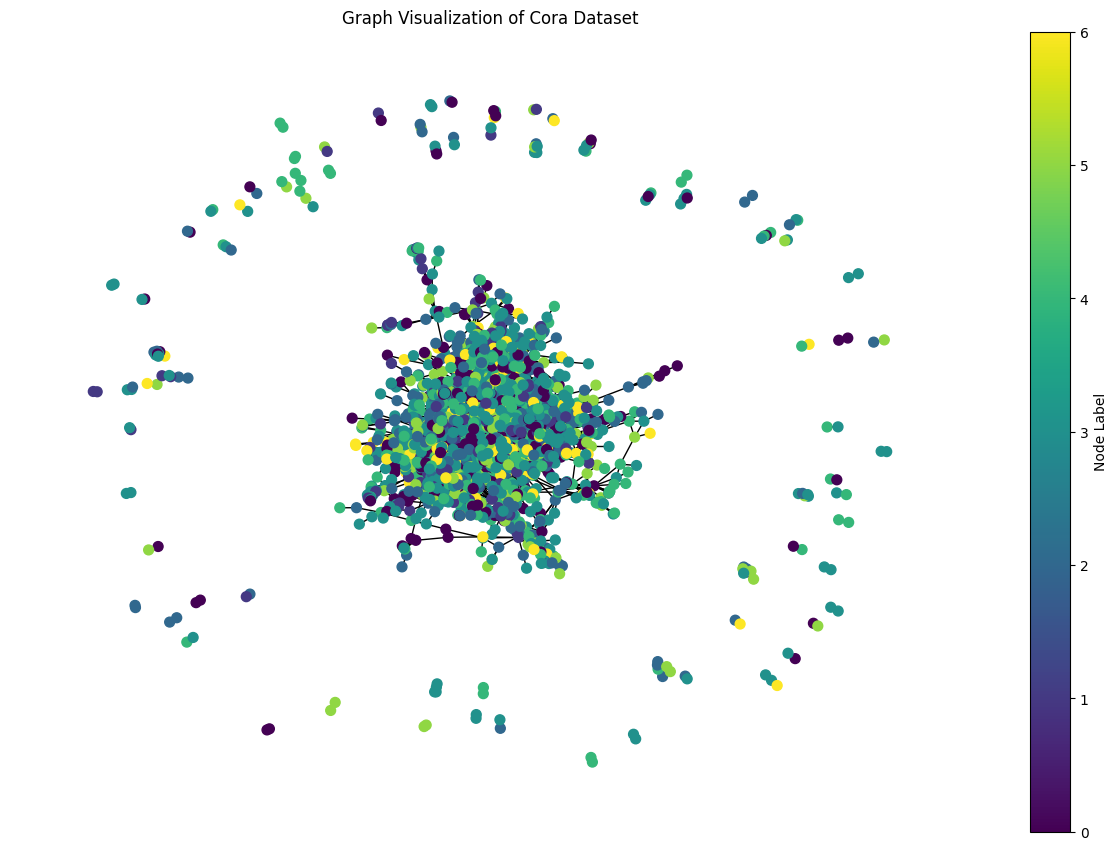

In [ ]:
# Convert edge index to a NetworkX graph
edge_index = data.edge_index.numpy()
G = nx.Graph()
edges = [(edge_index[0, i], edge_index[1, i]) for i in range(edge_index.shape[1])]
G.add_edges_from(edges)

# Get node labels (for coloring the nodes based on their class)
node_labels = data.y.numpy()

# Define a colormap
cmap = plt.get_cmap('viridis')

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, node_color=node_labels, cmap=cmap, node_size=50, with_labels=False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=node_labels.min(), vmax=node_labels.max()))
sm.set_array([])
plt.colorbar(sm, label='Node Label')
plt.title('Graph Visualization of Cora Dataset')
plt.show()

### Visualization of the original embeddings
To visualize the node features (data.x) using t-SNE (t-distributed Stochastic Neighbor Embedding), we can first reduce the dimensionality of the features using t-SNE and then plot the resulting embeddings.

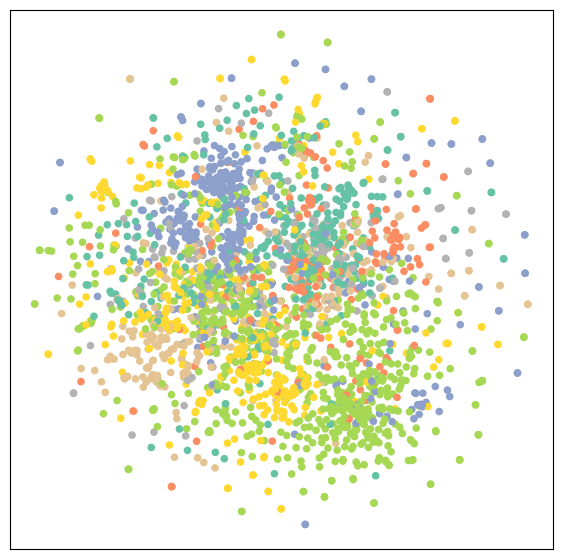

In [ ]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(h[:, 0], h[:, 1], s=20, c=color, cmap="Set2")
    plt.show()

# Perform t-SNE for visualization
from sklearn.manifold import TSNE


colors = data.y.cpu().numpy()
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(data.x.cpu().numpy())
visualize(embeddings, colors)

As we can see, the classes are not well-separated in the t-SNE visualization

### Define the GCN Model
We define a Graph Convolutional Network (GCN) model. This model consists of two graph convolution layers. The first layer reduces the feature dimensions and applies a ReLU activation. The second layer produces the final class scores.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

### Train the Model
We set up the device, model, optimizer, and loss function. The training loop runs for 200 epochs, where we update the model parameters using the Adam optimizer.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# In training mode, dropout will randomly zero some elements
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.9508405923843384
Epoch 20, Loss: 0.3261379897594452
Epoch 40, Loss: 0.08078951388597488
Epoch 60, Loss: 0.056916892528533936
Epoch 80, Loss: 0.08054760843515396
Epoch 100, Loss: 0.041038624942302704
Epoch 120, Loss: 0.039840806275606155
Epoch 140, Loss: 0.0295025072991848
Epoch 160, Loss: 0.03184640780091286
Epoch 180, Loss: 0.024283133447170258
Epoch 200, Loss: 0.03411884605884552
Epoch 220, Loss: 0.0251845084130764
Epoch 240, Loss: 0.02617962472140789
Epoch 260, Loss: 0.018578026443719864
Epoch 280, Loss: 0.03774214908480644
Epoch 300, Loss: 0.023440754041075706
Epoch 320, Loss: 0.018076982349157333
Epoch 340, Loss: 0.019027551636099815
Epoch 360, Loss: 0.021468758583068848
Epoch 380, Loss: 0.01751789078116417
Epoch 400, Loss: 0.013986448757350445
Epoch 420, Loss: 0.01645762473344803
Epoch 440, Loss: 0.026126112788915634
Epoch 460, Loss: 0.02427852712571621
Epoch 480, Loss: 0.014968769624829292


### Evaluate the Model
After training, we evaluate the model on the test set. We calculate the accuracy by comparing the predicted classes with the true classes for the test nodes.



In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8150


### Visualize the embeddings from the last layer
Finally, we visualize the node embeddings using t-SNE. We reduce the dimensionality of the node features to 2D for visualization and plot the nodes, coloring them by their predicted classes.

In [ ]:
def hook(module, input, output):
    # Store the output of the layer (embeddings)
    global hook_embeddings
    hook_embeddings = input[0].cpu().numpy()

# Register the hook on the desired layer (self.conv2)
hook_handle = model.conv2.register_forward_hook(hook)

# Set the model to evaluation mode
model.eval()

# Forward pass through the model
with torch.no_grad():
    _ = model(data)  # Pass data through the model to trigger the hook

# Remove the hook
hook_handle.remove()

# Visualize the embeddings
hook_embeddings

array([[0.01152407, 0.        , 0.        , ..., 0.32452393, 0.04009324,
        1.014073  ],
       [1.744094  , 0.36449158, 1.639931  , ..., 0.        , 1.9663644 ,
        0.        ],
       [1.28755   , 0.        , 0.9637768 , ..., 0.03409061, 1.5482569 ,
        0.1045503 ],
       ...,
       [0.13279465, 1.1439499 , 0.44825658, ..., 1.4325088 , 0.22960567,
        0.9234209 ],
       [0.34413707, 0.        , 0.        , ..., 0.76253814, 0.45013997,
        0.92053646],
       [0.30335316, 0.        , 0.        , ..., 0.67025137, 0.37918764,
        0.969536  ]], dtype=float32)

* We defined a hook function named hook that takes three arguments: module, input, and output. Since we want to access the embeddings before the self.conv2 layer, we extract the input to the layer from the input tuple.

* The hook is registered on the desired layer (self.conv2) using the register_forward_hook method.

* We set the model to evaluation mode and perform a forward pass through the model. The hook is triggered during the forward pass, and the embeddings (input to self.conv2) are stored in the embeddings variable.

* After obtaining the embeddings, we remove the hook to prevent any unintended side effects.

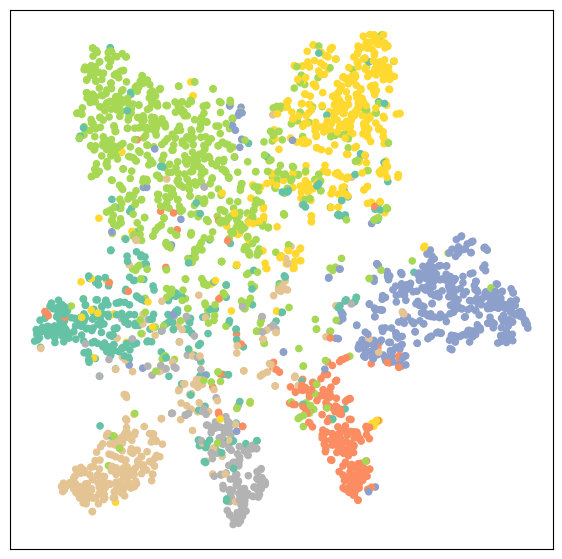

In [ ]:
colors = data.y.cpu().numpy()
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(hook_embeddings)
visualize(embeddings, colors)

We observe that the classes are well-separated when visualizing the embeddings of the last layer. This suggests that the model has learned a representation of the data that effectively captures the underlying class structure.